# topic-grid

Create a grid that represents the fit between a natural language client question and a research document. The fit can be quantified using any method we choose that is tested and robust. 

In [1]:
# Initialize with basic packages
%run include-2-shared-functions.ipynb

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


/home/jsub10/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/home/jsub10/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [97]:
#### DATA GENERATION PARAMETERS ####

# Set the number of questions and the number of research documents
NUM_QUESTIONS = 5
NUM_DOCS = 10

# Set up some ranges
dict_ranges = {'low': [0,0.25], 'med': [0.25,0.5], 'high': [0.5,0.75], 'vhigh': [0.75,1]}

# Threshold value for determining whether demand fits supply
FIT = 0.7 # anything equal or greater than FIT will count as demand satisfying supply

In [31]:
def generate_grid(ranges, num_q, num_docs):
    '''
    Generate a topic grid. Each row of the topic grid is a list of numbers, each number between 0 and 1. 
    Each row stands for a question. The numbers in the row represent the documents -- each number is a measure of the how well the document "fits" the question.
    Fit can be quantified in any way you choose -- when a document fit is high it means the document answers that question well. 
    
    num_q specifies the number of questions -- the number of rows in the grid. 
    num_docs specifies the number of documents -- the number of columns in the grid.
    
    USES constrained_sum_sample_pos in include-2-shared-functions
    
    '''
    # Want each row to be random but not uniformly random. To do this, let's randomize 
    ## how many low, medium, and high values we want in the row. 
    # Get the num of ranges we have in ranges
    num_ranges = len(ranges)
    # For each range get the number of values to generate
    grid_lists = []
    for i in range(num_q):
        # Create the number of values to generate in each range
        nums_in_range = constrained_sum_sample_pos(num_ranges, num_docs)
        partial_rows = []
        for j in range(len(nums_in_range)):
            partial_row = [round(random.uniform(list(ranges.values())[j][0],list(ranges.values())[j][1]), 2) for k in range(nums_in_range[j])]
            partial_rows.append(partial_row)
        # A separate list for each range is now created
        ## Combine those separate lists into one single list to create the row
        row = flatten_list(partial_rows)
        # To keep the order of the low, medium, and high values unpredictable, shuffle the row
        random.shuffle(row)
        grid_lists.append(row)
        
    # The grid lists are now created
    ## Turn it into a dataframe
    column_names = ['Doc ' + str(i+1) for i in range(num_docs)]
    row_idx = ['Q' + str(i+1) for i in range(num_q)]
    df_grid = pd.DataFrame(grid_lists)
    df_grid.columns = column_names
    df_grid.index = row_idx
    
    return df_grid
    

In [119]:
df_grid = generate_grid(ranges=dict_ranges, num_q=NUM_QUESTIONS, num_docs=NUM_DOCS)
df_grid

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10
Q1,0.80,0.16,0.40,0.70,0.18,0.73,0.47,0.16,0.55,0.84
Q2,0.72,0.75,0.20,0.92,0.21,0.02,0.57,0.55,0.50,0.18
Q3,0.21,0.51,0.97,0.50,0.55,0.48,0.68,0.51,0.39,0.83
Q4,0.83,0.89,0.23,0.20,0.26,0.14,0.82,0.72,0.02,0.78
Q5,0.00,0.46,0.38,0.41,0.35,0.67,0.47,0.82,0.84,0.84


In [149]:
def grid_stats(df_grid, fit_thresh):
    '''
    Calculate the coverage of each question/topic across the documents (Demand Covered by Supply) and
    the coverage of each document across the questions (Supply Covered by Demand). 
    
    df_grid is the output of the generate_grid function
    fit_thresh is the fitness floor set in the FIT constant
    
    '''
    # For each row of df_grid, calculate the percentage of documents that fit the question
    row_percentages = []
    
    for i in range(len(df_grid)):
        row_vals = df_grid.iloc[i,:].values
        # Row values and ids that are greater than the fit_thresh
        row_vals_above = [[idx, val] for idx,val in enumerate(row_vals) if val >= fit_thresh]
        num_row_vals_above = len([x[1] for x in row_vals_above])
        row_percentage = round((num_row_vals_above/len(row_vals))*100, 0)
        row_percentages.append(row_percentage)
        
    # For each column of df_grid, calculate the percentage of questions that fit the document
    col_percentages = []
    for i in range(df_grid.shape[1]):
        col_vals = df_grid.iloc[:,i].values
        col_vals_above = [[idx, val] for idx,val in enumerate(col_vals) if val >= fit_thresh]
        num_col_vals_above = len([x[1] for x in col_vals_above])
        col_percentage = round((num_col_vals_above/len(col_vals))*100, 0)
        col_percentages.append(col_percentage)
    
    
    # Add a column to df_grid with the row_percentages
    df1 = df_grid.copy()
    df1['Question Coverage %'] = row_percentages
    
    # Add a row to df1 with the col_percentages
    df2 = pd.DataFrame(columns=list(df1))
    df2.loc[0] = col_percentages + [0]
    df2.index = ['Document Coverage %']
    
    df_out = pd.concat([df1, df2])
    
    return df_out
        

In [150]:
grid_stats(df_grid, fit_thresh=0.5)

TypeError: Index(...) must be called with a collection of some kind, 'Document Coverage %' was passed

In [125]:
[1,2] +[3]

[1, 2, 3]

In [124]:
# For each row, calculate the percentage of documents that have fit higher than threshold value F. 
## Then plot each question on the x axis and the percentage of documents covering the question on the y axis.
df_grid.iloc[0].values

array([0.8 , 0.16, 0.4 , 0.7 , 0.18, 0.73, 0.47, 0.16, 0.55, 0.84])

In [42]:
[[idx, val] for idx,val in enumerate(df_grid.iloc[0].values) if val >= FIT]

[[1, 0.97]]

In [45]:
df_grid.shape[0]

10

In [46]:
df_grid.index.values

array(['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10'],
      dtype=object)

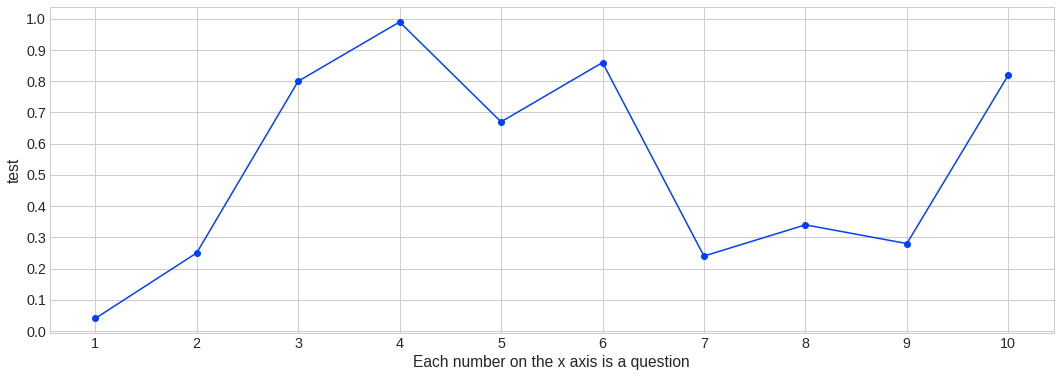

In [72]:
x_values = [x[1:] for x in df_grid.index.values]
y_values = df_grid.iloc[0].values
fig, ax = plt.subplots(figsize=(18,6))
ax.set_yticks(list(np.arange(-0.1,1.5,0.1)))
ax.set_xlabel("Each number on the x axis is a question")
ax.set_ylabel("test")
plt.plot(x_values, y_values, color='b', marker='o')

## ROUGH WORK

In [8]:
# Start by generating a random list of reals between 0 and 1
## random.choices works in Python 3.6 and greater
random.choices([0,1], weights=None,cum_weights=None, k=12)

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]

In [59]:
fit_row = [random.random() for i in range(5)]
fit_row

[0.125294475321169,
 0.4115625129619517,
 0.6828747630165201,
 0.14136476335652293,
 0.6256702823151284]

In [60]:
random.shuffle(fit_row)
fit_row

[0.125294475321169,
 0.6828747630165201,
 0.6256702823151284,
 0.14136476335652293,
 0.4115625129619517]

In [22]:
round(random.uniform(0,.25), 2)

0.11

In [51]:
constrained_sum_sample_pos(4, 100)

[18, 29, 32, 21]

In [24]:
len(dict_ranges)

3

In [31]:
list(dict_ranges.values())[0]

[0, 0.25]

In [52]:
flatten_list([[0.22, 0.12, 0.17, 0.07, 0.15, 0.13, 0.16], [0.44], [0.95, 0.83]])

[0.22, 0.12, 0.17, 0.07, 0.15, 0.13, 0.16, 0.44, 0.95, 0.83]